In [3]:
#Important imports to be added

import pandas as pd
import numpy as np
!pip install swifter
import re,nltk,swifter
import matplotlib.pyplot as plt
import seaborn as sn
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import nltk
#downloading stopwords library from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
#reading csv and filling out missing values
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/train-balanced-sarcasm.csv')
print(df.head())
# Sample 150,000 random rows
df = df.sample(n=10000, random_state=42)
df = df.fillna('')

   label                                            comment     author  \
0      0                                         NC and NH.  Trumpbart   
1      0  You do know west teams play against west teams...  Shbshb906   
2      0  They were underdogs earlier today, but since G...   Creepeth   
3      0  This meme isn't funny none of the "new york ni...  icebrotha   
4      0                    I could use one of those tools.  cush2push   

            subreddit  score  ups  downs     date          created_utc  \
0            politics      2   -1     -1  2016-10  2016-10-16 23:55:23   
1                 nba     -4   -1     -1  2016-11  2016-11-01 00:24:10   
2                 nfl      3    3      0  2016-09  2016-09-22 21:45:37   
3  BlackPeopleTwitter     -8   -1     -1  2016-10  2016-10-18 21:03:47   
4  MaddenUltimateTeam      6   -1     -1  2016-12  2016-12-30 17:00:13   

                                      parent_comment  
0  Yeah, I get that argument. At this point, I'd ...  


In [8]:
#taking only necessary comments
df = df[['label','comment','author','score','created_utc','parent_comment']]

In [9]:
df.head()

,label,comment,author,score,created_utc,parent_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes)
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...


**Exploratory Data Analysis**

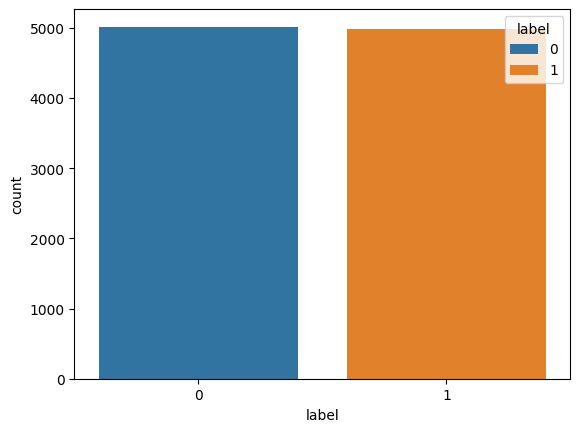

The percentage of Non-Sarcastic comments is 50.14999999999999
The percentage of Sarcastic comments is 49.85


In [10]:
import seaborn as sns
sns.countplot(x="label",data=df,hue="label")
plt.show()
print("The percentage of Non-Sarcastic comments is",sum(df['label']==0)/(len(df['label']))*100)
print("The percentage of Sarcastic comments is",sum(df['label']==1)/(len(df['label']))*100)

We can see from the countplot that this dataset is balanced

In [11]:
def clean_text(comment):

    # Cleaning the text by removing links, usernames, HTML tags, expansion of words, username removal, etc.
    text = str(comment)

    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)

    # Remove HTML tags
    text = re.sub("<.*?>", " ", text)

    # Remove numbers
    text = re.sub(r"[0-9]+", " ", text)

    # Remove reddit handles
    text = re.sub(r"@[A-Za-z0-9]+", " ", text)

    # Replace contractions
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    # Remove special characters
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')

    return text

# Apply text cleaning
df["cleanV1_comment"] = df["comment"].apply(clean_text)


In [12]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an..."


In [13]:
#function to lowercase all except all caps word
def lowercase_except_caps(sentence):
  #print(sentence)
  words = sentence.split()
  modified_words = []
  for word in words:
    if word.isupper():
      modified_words.append(word)
    else:
      modified_words.append(word.lower())
  return " ".join(modified_words)

**Abbreviation Replacement**


In [14]:
#csv to dataframe
abbrslang=pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Abbr.csv')
abbrslang

,Abbr,Meaning
0,@TEOTD,At the end of the day
1,143,I love you
2,2G2BT,Too good to be true
3,404,I don't know
4,4EAE,Forever and ever
...,...,...
426,BS,Bullshit
427,NYC,New York City
428,VR,Virtual Reality
429,GTA,Grand Theft Auto


In [15]:
abbrslangDict=abbrslang.to_dict(orient='records')
abbrslangDict

[{'Abbr': '@TEOTD', 'Meaning': 'At the end of the day'},
 {'Abbr': '143', 'Meaning': 'I love you'},
 {'Abbr': '2G2BT', 'Meaning': 'Too good to be true'},
 {'Abbr': '404', 'Meaning': "I don't know"},
 {'Abbr': '4EAE', 'Meaning': 'Forever and ever'},
 {'Abbr': 'A3', 'Meaning': 'Anytime, anywhere, anyplace'},
 {'Abbr': 'AAF', 'Meaning': 'As a matter of fact'},
 {'Abbr': 'AAK', 'Meaning': 'Asleep at keyboard'},
 {'Abbr': 'AAMOI', 'Meaning': 'As a matter of interest'},
 {'Abbr': 'AAP', 'Meaning': 'Always a pleasure'},
 {'Abbr': 'AAR', 'Meaning': 'At any rate'},
 {'Abbr': 'AAS', 'Meaning': 'Alive and smiling'},
 {'Abbr': 'ACK', 'Meaning': 'Acknowledge'},
 {'Abbr': 'ADD', 'Meaning': 'Address'},
 {'Abbr': 'ADN', 'Meaning': 'Any day now'},
 {'Abbr': 'ADR', 'Meaning': 'Address'},
 {'Abbr': 'AEAP', 'Meaning': 'As early as possible'},
 {'Abbr': 'AFAIK', 'Meaning': 'As far as I know'},
 {'Abbr': 'AFK', 'Meaning': 'Away from keyboard'},
 {'Abbr': 'AFPOE', 'Meaning': 'A fresh pair of eyes'},
 {'Abbr'

In [16]:
import re
def expand_abbr(text, abbr_dict):
    # Regex for 2 or more capital letters (excluding common abbreviations)
    pattern1 = r"\b([A-Z]{2,}(?!\.[A-Z]{2,}))\b"

    # Regex for common abbreviations (Mr., Mrs., etc.)
    pattern2 = r"\b([A-Z]{2,}\.?)\b"

    # Combine both patterns
    combined_pattern = re.compile("|".join([pattern1, pattern2]))

    detected_abbr = []  # List to store detected abbreviations

    def expand_match(match):
        matched_abbr = match.group()
        detected_abbr.append(matched_abbr)  # Store detected abbreviation
        for entry in abbr_dict:
            if matched_abbr.upper() == entry['Abbr']:
                return entry['Meaning']
        return matched_abbr  # Use default if not found

    if not isinstance(text, str):
        text = str(text)  # Convert non-string inputs to strings

    expanded_text = combined_pattern.sub(expand_match, text)

    return expanded_text, detected_abbr

df['abbr_comment'], df['detected_abbr'] = zip(*df['cleanV1_comment'].apply(expand_abbr, args=(abbrslangDict,)))
df.head(5)


,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[]
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[]
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[]
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[]
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ]


In [17]:
from collections import Counter
import pandas as pd

# Flatten the list of lists into a single list
detected_abbr_flat = [word for sublist in df['detected_abbr'] if sublist for word in sublist]

# Count the frequency of each word
word_freq = Counter(detected_abbr_flat)

# Convert the Counter object to a DataFrame
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Save the DataFrame to a CSV file
word_freq_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Abbr_word_frequency.csv')


In [18]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Abbr_log.csv', index=False)

In [19]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[]
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[]
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[]
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[]
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ]


# Slang Handling

In [20]:
import pandas as pd

# Load the CSV file into a DataFrame
slangs_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Slangs.csv')

# Create a dictionary from the DataFrame
slangs_dict = dict(zip(slangs_df['slangs'], slangs_df['meanings']))

# Function to replace slangs in a sentence and store detected slangs
def replace_slangs(sentence):
    words = sentence.split()
    replaced_words = []
    detected_slangs = []
    for word in words:
        meaning = slangs_dict.get(word, word)
        if meaning != word:
            detected_slangs.append((word, meaning))
        replaced_words.append(meaning)
    return ' '.join(replaced_words), detected_slangs

# Load your dataset into a DataFrame (assuming your dataset is called 'df' and has a column 'comment')
df['slang_comment'], df['detected_slangs'] = zip(*df['abbr_comment'].apply(replace_slangs))

# Display the updated DataFrame
df

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,slang_comment,detected_slangs
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[],And he sure as hell is successful!,[]
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[],"wait, you have to win the candidates to challe...",[]
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,[]
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[],"Funny thing, most of the girl pants I have bou...",[]
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ],"Also Ranch dressing, because LBJ was Texan, an...",[]
...,...,...,...,...,...,...,...,...,...,...,...
989368,0,And the drop-bears... can't forget those fuzzy...,Bcteagirl,1,2011-10-27 20:09:03,That's why the food is expensive. The farmer's...,And the drop-bears... can not forget those fuz...,And the drop-bears... can not forget those fuz...,[],And the drop-bears... can not forget those fuz...,[]
292333,0,o7 Hail!,AvalonTreman,4,2016-07-03 19:36:19,"Another Avalon! Hail, brother.",o Hail!,o Hail!,[],o Hail!,[]
546581,1,3,tangemann,4,2015-08-04 19:31:59,"On a scale of one to Gaben, how empty is your ...",,,[],,[]
936260,1,Repetitive fire hydrant and trash can placing ...,UsedCheese,43,2013-08-02 16:16:11,Screenshot Analysis,Repetitive fire hydrant and trash can placing ...,Repetitive fire hydrant and trash can placing ...,[],Repetitive fire hydrant and trash can placing ...,[]


In [21]:
from collections import Counter
import pandas as pd

# Flatten the list of lists into a single list
detected_slang_flat = [word for sublist in df['detected_slangs'] if sublist for word in sublist]

# Count the frequency of each word
word_freq_slang = Counter(detected_slang_flat)

# Convert the Counter object to a DataFrame
word_freq_slang_df = pd.DataFrame.from_dict(word_freq_slang, orient='index', columns=['Slang_Freq'])

# Sort the DataFrame by frequency in descending order
word_freq_slang_df = word_freq_slang_df.sort_values(by='Slang_Freq', ascending=False)

# Save the DataFrame to a CSV file
word_freq_slang_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Slang_word_frequency.csv')

In [22]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Slang_log.csv', index=False)

In [23]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,slang_comment,detected_slangs
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[],And he sure as hell is successful!,[]
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[],"wait, you have to win the candidates to challe...",[]
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,[]
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[],"Funny thing, most of the girl pants I have bou...",[]
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ],"Also Ranch dressing, because LBJ was Texan, an...",[]


In [24]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string

# Remove punctuation marks
df['punct_comment'] = df['slang_comment'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation or char in ['?', '!','...']]))
# Tokenize the text
df['tokenized_comment'] = df['punct_comment'].apply(lambda x: word_tokenize(x))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [25]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,slang_comment,detected_slangs,punct_comment,tokenized_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[],And he sure as hell is successful!,[],And he sure as hell is successful!,"[And, he, sure, as, hell, is, successful, !]"
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[],"wait, you have to win the candidates to challe...",[],wait you have to win the candidates to challen...,"[wait, you, have, to, win, the, candidates, to..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,"[I, mean, how, could, anyone, not, see, that, ..."
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[],"Funny thing, most of the girl pants I have bou...",[],Funny thing most of the girl pants I have boug...,"[Funny, thing, most, of, the, girl, pants, I, ..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ],"Also Ranch dressing, because LBJ was Texan, an...",[],Also Ranch dressing because LBJ was Texan and ...,"[Also, Ranch, dressing, because, LBJ, was, Tex..."


In [26]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 4.6 MB/s eta 0:00:00


In [27]:
import emoji
# Function to check if a string contains emojis
def has_emoji(text):
    #text = str(text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text))

# Function to replace emojis with their meanings
def replace_emojis(text):
    return emoji.demojize(text)

# Apply emoji replacement and check for emojis
df["has_emoji"] = df["tokenized_comment"].astype(str).apply(has_emoji)
# df["emoji_replaced_comment"] = df["tokenized_abbr_comment"].astype(str).apply(replace_emojis)

# Apply emoji replacement and create a pandas Series
emoji_replaced_series = df["tokenized_comment"].astype(str).apply(replace_emojis)

# Assign the pandas Series to the DataFrame as a new column
df["emoji_replaced_comment"] = emoji_replaced_series
print(type(df['emoji_replaced_comment']))

<class 'pandas.core.series.Series'>


In [28]:
df['has_emoji'].value_counts()[False]

10000

**This upper value is same as the total number of comments, which shows that we don't have any emojis in the dataset**

In [29]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,slang_comment,detected_slangs,punct_comment,tokenized_comment,has_emoji,emoji_replaced_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[],And he sure as hell is successful!,[],And he sure as hell is successful!,"[And, he, sure, as, hell, is, successful, !]",False,"['And', 'he', 'sure', 'as', 'hell', 'is', 'suc..."
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[],"wait, you have to win the candidates to challe...",[],wait you have to win the candidates to challen...,"[wait, you, have, to, win, the, candidates, to...",False,"['wait', 'you', 'have', 'to', 'win', 'the', 'c..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,"[I, mean, how, could, anyone, not, see, that, ...",False,"['I', 'mean', 'how', 'could', 'anyone', 'not',..."
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[],"Funny thing, most of the girl pants I have bou...",[],Funny thing most of the girl pants I have boug...,"[Funny, thing, most, of, the, girl, pants, I, ...",False,"['Funny', 'thing', 'most', 'of', 'the', 'girl'..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ],"Also Ranch dressing, because LBJ was Texan, an...",[],Also Ranch dressing because LBJ was Texan and ...,"[Also, Ranch, dressing, because, LBJ, was, Tex...",False,"['Also', 'Ranch', 'dressing', 'because', 'LBJ'..."


**Stop words removal**

In [30]:
import ast
from nltk.corpus import stopwords

# Import stopwords and define custom set
stops = set(stopwords.words('english')) - {'no', 'not', 'nor', 'against', 'above', 'below', 'off', 'own'}

# Apply stopword removal to the emoji_replaced_comment column
def remove_stopwords(comment):
    return [word for word in ast.literal_eval(comment) if word.lower() not in stops]

df["cleaned_comment"] = df["emoji_replaced_comment"].apply(remove_stopwords)

In [31]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,slang_comment,detected_slangs,punct_comment,tokenized_comment,has_emoji,emoji_replaced_comment,cleaned_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[],And he sure as hell is successful!,[],And he sure as hell is successful!,"[And, he, sure, as, hell, is, successful, !]",False,"['And', 'he', 'sure', 'as', 'hell', 'is', 'suc...","[sure, hell, successful, !]"
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[],"wait, you have to win the candidates to challe...",[],wait you have to win the candidates to challen...,"[wait, you, have, to, win, the, candidates, to...",False,"['wait', 'you', 'have', 'to', 'win', 'the', 'c...","[wait, win, candidates, challenge, world, titl..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,"[I, mean, how, could, anyone, not, see, that, ...",False,"['I', 'mean', 'how', 'could', 'anyone', 'not',...","[mean, could, anyone, not, see, antique, shopguy]"
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[],"Funny thing, most of the girl pants I have bou...",[],Funny thing most of the girl pants I have boug...,"[Funny, thing, most, of, the, girl, pants, I, ...",False,"['Funny', 'thing', 'most', 'of', 'the', 'girl'...","[Funny, thing, girl, pants, bought, pretty, go..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ],"Also Ranch dressing, because LBJ was Texan, an...",[],Also Ranch dressing because LBJ was Texan and ...,"[Also, Ranch, dressing, because, LBJ, was, Tex...",False,"['Also', 'Ranch', 'dressing', 'because', 'LBJ'...","[Also, Ranch, dressing, LBJ, Texan, not, take,..."


**Cloud Map for highest occuring words in both(sarcastic & non-sarcastic) the categories before cleaning**

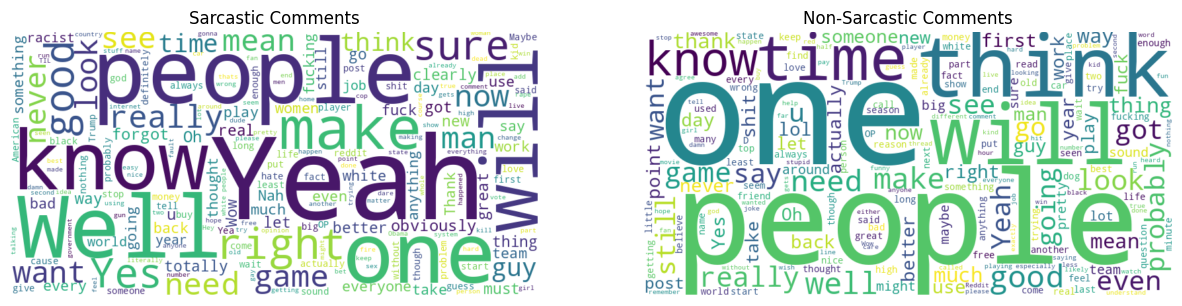

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter sarcastic and non-sarcastic comments
sarcastic_comments = ' '.join(df[df['label'] == 1]['comment'])
non_sarcastic_comments = ' '.join(df[df['label'] == 0]['comment'])

# Generate word clouds for sarcastic and non-sarcastic comments
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_comments)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_comments)

# Plot the word clouds
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Comments')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Comments')
plt.axis('off')

plt.show()

**Cloud Map for highest occuring words in both(sarcastic & non-sarcastic) the categories after cleaning**

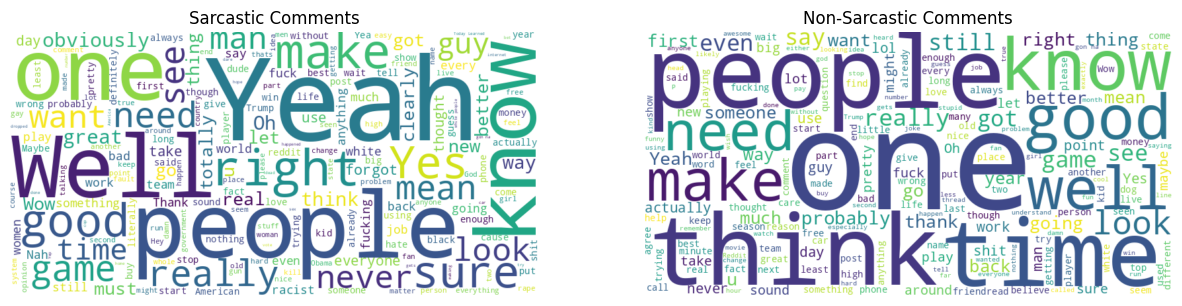

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join lists of words in cleaned_comment column to form strings
sarcastic_comments = ' '.join(df[df['label'] == 1]['cleaned_comment'].apply(lambda x: ' '.join(x)))
non_sarcastic_comments = ' '.join(df[df['label'] == 0]['cleaned_comment'].apply(lambda x: ' '.join(x)))

# Generate word clouds for sarcastic and non-sarcastic comments
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_comments)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_comments)

# Plot the word clouds
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Comments')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Comments')
plt.axis('off')

plt.show()

**GloVe Embedding**

In [34]:
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [35]:
import spacy
import numpy as np

# Load SpaCy with GloVe vectors
nlp = spacy.load("en_core_web_md")  # Load the medium-sized English model with GloVe vectors

# Define function to compute average GloVe embeddings for a text
def compute_average_glove_embedding(text, nlp_model):
    doc = nlp_model(' '.join(text))
    # Get vectors for each token in the text
    word_vectors = [token.vector for token in doc if not token.is_stop]
    if word_vectors:
        # Compute average embedding
        average_embedding = np.mean(word_vectors, axis=0)
        return average_embedding
    else:
        # Return zeros if no valid word vectors found
        return np.zeros(nlp_model.vocab.vectors_length)

# Compute average GloVe embeddings for each comment
df['glove_embedding'] = df['cleaned_comment'].apply(lambda x: compute_average_glove_embedding(x, nlp))


In [36]:
df

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,slang_comment,detected_slangs,punct_comment,tokenized_comment,has_emoji,emoji_replaced_comment,cleaned_comment,glove_embedding
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[],And he sure as hell is successful!,[],And he sure as hell is successful!,"[And, he, sure, as, hell, is, successful, !]",False,"['And', 'he', 'sure', 'as', 'hell', 'is', 'suc...","[sure, hell, successful, !]","[1.116775, 0.205675, -2.4696097, -1.0811, 2.54..."
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[],"wait, you have to win the candidates to challe...",[],wait you have to win the candidates to challen...,"[wait, you, have, to, win, the, candidates, to...",False,"['wait', 'you', 'have', 'to', 'win', 'the', 'c...","[wait, win, candidates, challenge, world, titl...","[-1.0515015, 1.8250101, -0.5487285, 0.2253029,..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,"[I, mean, how, could, anyone, not, see, that, ...",False,"['I', 'mean', 'how', 'could', 'anyone', 'not',...","[mean, could, anyone, not, see, antique, shopguy]","[-1.5973034, -1.8116966, 0.23922665, 0.2648633..."
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[],"Funny thing, most of the girl pants I have bou...",[],Funny thing most of the girl pants I have boug...,"[Funny, thing, most, of, the, girl, pants, I, ...",False,"['Funny', 'thing', 'most', 'of', 'the', 'girl'...","[Funny, thing, girl, pants, bought, pretty, go...","[-0.82109106, 0.7838919, -2.4705956, -0.6393, ..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ],"Also Ranch dressing, because LBJ was Texan, an...",[],Also Ranch dressing because LBJ was Texan and ...,"[Also, Ranch, dressing, because, LBJ, was, Tex...",False,"['Also', 'Ranch', 'dressing', 'because', 'LBJ'...","[Also, Ranch, dressing, LBJ, Texan, not, take,...","[-0.14728002, -0.21150999, -0.9164, -1.100585,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989368,0,And the drop-bears... can't forget those fuzzy...,Bcteagirl,1,2011-10-27 20:09:03,That's why the food is expensive. The farmer's...,And the drop-bears... can not forget those fuz...,And the drop-bears... can not forget those fuz...,[],And the drop-bears... can not forget those fuz...,[],And the dropbears can not forget those fuzzy b...,"[And, the, dropbears, can, not, forget, those,...",False,"['And', 'the', 'dropbears', 'can', 'not', 'for...","[dropbears, not, forget, fuzzy, bastards]","[-1.6319776, 0.7879532, -0.417075, -0.01587498..."
292333,0,o7 Hail!,AvalonTreman,4,2016-07-03 19:36:19,"Another Avalon! Hail, brother.",o Hail!,o Hail!,[],o Hail!,[],o Hail!,"[o, Hail, !]",False,"['o', 'Hail', '!']","[Hail, !]","[4.33365, -0.33375, -2.3341148, -2.743255, 3.1..."
546581,1,3,tangemann,4,2015-08-04 19:31:59,"On a scale of one to Gaben, how empty is your ...",,,[],,[],,[],False,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
936260,1,Repetitive fire hydrant and trash can placing .

**lemmetization**

In [37]:
# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

def lemma(comment):
    # Join the list of words into a single string
    text = ' '.join(comment)
    # Tokenize the text
    words = word_tokenize(text)
    # Lemmatize and remove stopwords
    cleaned_words = [token.lemma_ for token in nlp(' '.join(words)) if token.text not in stops]
    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

# Apply lemmatization
df["lemma_comment"] = df["cleaned_comment"].apply(lemma)

In [38]:
df.tail(10)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,slang_comment,detected_slangs,punct_comment,tokenized_comment,has_emoji,emoji_replaced_comment,cleaned_comment,glove_embedding,lemma_comment
912509,1,"Thanks, that cleared it up.",Rtwk,9,2013-10-26 19:19:51,Sat at a police station for a few hours. Came ...,"Thanks, that cleared it up.","Thanks, that cleared it up.",[],"Thanks, that cleared it up.",[],Thanks that cleared it up,"[Thanks, that, cleared, it, up]",False,"['Thanks', 'that', 'cleared', 'it', 'up']","[Thanks, cleared]","[1.5462499, -0.20144999, -1.876895, 0.02161999...",thank clear
899860,0,he's so cute that you could hardly believe he'...,smurgleburf,1,2014-06-15 20:21:51,Bears eat dirt and moss to plug their system s...,he is so cute that you could hardly believe he...,he is so cute that you could hardly believe he...,[],he is so cute that you could hardly believe he...,[],he is so cute that you could hardly believe he...,"[he, is, so, cute, that, you, could, hardly, b...",False,"['he', 'is', 'so', 'cute', 'that', 'you', 'cou...","[cute, could, hardly, believe, would, take, he...","[0.8579996, -0.22214378, -2.9086769, -1.342003...",cute could hardly believe would take head off ...
89881,1,But... But... he went bankrupt!,CanIGetAc,1,2016-09-07 04:16:56,"When asked ""What would you do for a million do...",But... But... he went bankrupt!,But... But... he went bankrupt!,[],But... But... he went bankrupt!,[],But But he went bankrupt!,"[But, But, he, went, bankrupt, !]",False,"['But', 'But', 'he', 'went', 'bankrupt', '!']","[went, bankrupt, !]","[1.1069332, -1.7581667, -3.9768667, -3.1191998...",go bankrupt !
978690,1,Sodom and Gamora.,pi_over_3,1,2012-03-21 20:05:33,"Shhh! Don't tell people, or they will start ya...",Sodom and Gamora.,Sodom and Gamora.,[],Sodom and Gamora.,[],Sodom and Gamora,"[Sodom, and, Gamora]",False,"['Sodom', 'and', 'Gamora']","[Sodom, Gamora]","[1.2299, 0.63167, 2.2437751, -0.664205, -0.016...",Sodom Gamora
687283,0,I take some small comfort in the fact this man...,Biffingston,1,2015-04-03 18:48:09,Arnold Schwarzenegger 'Furious' Over GOP Suppo...,I take some small comfort in the fact this man...,I take some small comfort in the fact this man...,[],I take some small comfort in the fact this man...,[],I take some small comfort in the fact this man...,"[I, take, some, small, comfort, in, the, fact,...",False,"['I', 'take', 'some', 'small', 'comfort', 'in'...","[take, small, comfort, fact, man, never, presi...","[-0.18702158, 0.36241397, -2.5618198, 1.181655...",take small comfort fact man never president
989368,0,And the drop-bears... can't forget those fuzzy...,Bcteagirl,1,2011-10-27 20:09:03,That's why the food is expensive. The farmer's...,And the drop-bears... can not forget those fuz...,And the drop-bears... can not forget those fuz...,[],And the drop-bears... can not forget those fuz...,[],And the dropbears can not forget those fuzzy b...,"[And, the, dropbears, can, not, forget, those,...",False,"['And', 'the', 'dropbears', 'can', 'not', 'for...","[dropbears, not, forget, fuzzy, bastards]","[-1.6319776, 0.7879532, -0.417075, -0.01587498...",dropbear not forget fuzzy bastard
292333,0,o7 Hail!,AvalonTreman,4,2016-07-03 19:36:19,"Another Avalon! Hail, brother.",o Hail!,o Hail!,[],o Hail!,[],o Hail!,"[o, Hail, !]",False,"['o', 'Hail', '!']","[Hail, !]","[4.33365, -0.33375, -2.3341148, -2.743255, 3.1...",hail !
546581,1,3,tangemann,4,2015-08-04 19:31:59,"On a scale of one to Gaben, how empty is your ...",,,[],,[],,[],False,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",
936260,1,Repetitive fire hydrant and trash can placing ...,UsedCheese,43,2013-08-02 16:16:11,Screenshot Analysis,Repetitive fire hydrant and trash can placing ...,Repetitive fire hydrant and trash can placing ...,[],Repetitive fire hydrant and trash can placing ...,[],Repetitive fire hydrant and trash can placing ...,"[Repetitive, fire, hydrant, and, trash, can, p...",False,"

**TF-IDF Vectorization**

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df["lemma_comment"]

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
TfIdfMatrix = vectorizer.fit_transform(corpus)
print(TfIdfMatrix)

  (0, 9694)	0.7117831377662319
  (0, 4548)	0.5722237846510644
  (0, 9769)	0.40733856320175443
  (1, 10165)	0.4234434890488435
  (1, 11127)	0.3554569772769603
  (1, 1623)	0.46467010176552276
  (1, 1478)	0.4766054789515363
  (1, 11046)	0.3627865379868629
  (1, 10835)	0.34592020857615513
  (2, 9042)	0.5564385482856438
  (2, 401)	0.5327326046189932
  (2, 8855)	0.2709604023304385
  (2, 6887)	0.15808334922678405
  (2, 413)	0.3706302911378705
  (2, 2193)	0.29270640657657904
  (2, 6196)	0.2917505370412918
  (3, 7057)	0.10528939755180974
  (3, 8940)	0.23142990781213513
  (3, 5601)	0.21457480153820216
  (3, 8137)	0.1766857444030126
  (3, 8169)	0.1363021119386877
  (3, 3634)	0.1399696387011344
  (3, 2688)	0.19485559130636076
  (3, 7017)	0.19229356301237788
  (3, 10834)	0.23142990781213513
  :	:
  (9992, 783)	0.9091001720184941
  (9992, 4147)	0.4165775764919955
  (9993, 3980)	0.7071067811865476
  (9993, 9306)	0.7071067811865476
  (9994, 1935)	0.5255597226015409
  (9994, 7804)	0.4327292021468244
  

**Concatinating GloVe Embedding Matrices and Tf-Idf Vectors horizontaly to create single feature Matrices**

In [40]:
from scipy.sparse import hstack, csr_matrix
print("GloVe embeddings shape before csr:", df["glove_embedding"].shape)
# Convert the GloVe embeddings to a CSR matrix
glove_embeddings = csr_matrix(np.vstack(df["glove_embedding"].values))

# Print shapes for debugging
print("TfIdfMatrix shape:", TfIdfMatrix.shape)
print("GloVe embeddings after csr shape:", glove_embeddings.shape)

# Combine the TF-IDF matrix and the GloVe embeddings horizontally
combined_matrix = hstack([TfIdfMatrix, csr_matrix(df["glove_embedding"].to_list())])

# Print the shape of the combined matrix
print("Combined matrix shape:", combined_matrix.shape)


GloVe embeddings shape before csr: (10000,)
TfIdfMatrix shape: (10000, 11328)
GloVe embeddings after csr shape: (10000, 300)
Combined matrix shape: (10000, 11628)


In [41]:
print(combined_matrix)

  (0, 9694)	0.7117831377662319
  (0, 4548)	0.5722237846510644
  (0, 9769)	0.40733856320175443
  (0, 11328)	1.1167750358581543
  (0, 11329)	0.20567500591278076
  (0, 11330)	-2.4696097373962402
  (0, 11331)	-1.0810999870300293
  (0, 11332)	2.5414748191833496
  (0, 11333)	2.939802646636963
  (0, 11334)	1.2601025104522705
  (0, 11335)	1.6486749649047852
  (0, 11336)	-2.6000325679779053
  (0, 11337)	1.4555723667144775
  (0, 11338)	0.8994225859642029
  (0, 11339)	0.2915574908256531
  (0, 11340)	-1.5501799583435059
  (0, 11341)	3.6577248573303223
  (0, 11342)	2.2925374507904053
  (0, 11343)	-2.489224910736084
  (0, 11344)	1.2132599353790283
  (0, 11345)	-2.13112735748291
  (0, 11346)	-0.9687325358390808
  (0, 11347)	-1.1257050037384033
  (0, 11348)	2.1764025688171387
  (0, 11349)	0.10024247318506241
  :	:
  (9999, 11603)	0.3712550103664398
  (9999, 11604)	-0.338809996843338
  (9999, 11605)	-0.24210000038146973
  (9999, 11606)	-1.0734249353408813
  (9999, 11607)	1.8964999914169312
  (9999, 116

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 'labels' is a binary column indicating sarcasm (1) or not sarcasm (0)
X = combined_matrix
y = df["label"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
rf_classifier.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = rf_classifier.predict(X_train)

# Make predictions on the test set
y_test_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the model on training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Calculate the accuracy of the model on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.994875
Test Accuracy: 0.5805


**Evaluating the RF Classifier**

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Train the model on the training set
rf_classifier.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = rf_classifier.predict(X_train)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Make predictions on the testing set
y_test_pred = rf_classifier.predict(X_test)

# Calculate accuracy on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)



Train Accuracy: 0.994875
Test Accuracy: 0.5805
Precision: 0.5866228070175439
Recall: 0.5366098294884654
F1-score: 0.5605028810895757
Confusion Matrix:
 [[626 377]
 [462 535]]


**Model Interpretability using LIME (Local Interpretable Model-agnostic Explanations):**

In [50]:
# Check the type of values in the label column
label_types = set()
for val in df["label"]:
    label_types.add(type(val))

print("Types present in label column:", label_types)

# Check if the label column has values other than 0 and 1
unique_values = set(df["label"])
if len(unique_values - {0, 1}) > 0:
    print("Label column has values other than 0 and 1.")
else:
    print("Label column only has values 0 and 1.")


Types present in label column: {<class 'int'>}
Label column only has values 0 and 1.


In [51]:
!pip install lime

In [52]:
from lime import lime_tabular

# Convert feature names to strings
feature_names_str = [str(i) for i in range(X_train.shape[1])]

# Initialize LIME explainer
explainer = lime_tabular.LimeTabularExplainer(X_train.toarray(),
                                              feature_names=feature_names_str,
                                              class_names=['Non-Sarcastic', 'Sarcastic'],
                                              discretize_continuous=True)

# Define explanation function
def explain_prediction(instance_index):
    instance = X_test.toarray()[instance_index]
    explanation = explainer.explain_instance(instance, rf_classifier.predict_proba, num_features=10)
    explanation.show_in_notebook()

# Explain predictions for a specific instance (change instance_index accordingly)
instance_index = 135  # Change this index to explain predictions for different instances
explain_prediction(instance_index)